In [ ]:
#import argparse
import numpy as np
import pandas as pd
import re

#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch.cuda.amp import GradScaler

#import rdkit
#import math

import random
#from random import randrange
from random import shuffle

from typing import Optional, List, Tuple

#activation function
from packaging import version
from torch import Tensor

import logging
logger = logging.getLogger(__name__)


# In[2]:


from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import RDLogger

In [ ]:
random.__version__

AttributeError: module 'random' has no attribute '__version__'

In [ ]:
RDLogger.DisableLog('rdApp.*')

In [ ]:
device = 'cuda:2'
torch.set_default_dtype(torch.float32)
torch.set_default_device(device)

In [ ]:
data = pd.read_csv('/home/10714016/gpt/data_processed.csv', index_col = False)
data = data.dropna(axis=0).reset_index(drop=True)
#data.drop(['SPLIT'], axis=1, inplace=True)
data

,Unnamed: 0,SMILES,MW,logP,TPSA,SAS,QED,HBA,HBD,NumRotBonds,scaffold_SMILES,canonic_SMILES
0,0,CCCC(=O)NNC(=O)Nc1ccccc1,221.260,1.63940,70.23,1.684604,0.678917,2,3,3,c1ccccc1,CCCC(=O)NNC(=O)Nc1ccccc1
1,1,CC(=O)NC1CCC2(C)C(CCC3(C)C2C(=O)C=C2C4C(C)C(C)...,511.747,6.41230,83.47,5.071940,0.448510,3,2,2,O=C1C=C2C3CCCCC3CCC2C2CCC3CCCCC3C12,CC(=O)NC1CCC2(C)C(CCC3(C)C2C(=O)C=C2C4C(C)C(C)...
2,2,CC(=O)NC(C)Cc1ccc(C#Cc2ccnc(N3CCCC(F)C3)n2)cc1,380.467,2.88180,58.12,3.428927,0.829000,4,1,4,C(#Cc1ccnc(N2CCCCC2)n1)c1ccccc1,CC(=O)NC(C)Cc1ccc(C#Cc2ccnc(N3CCCC(F)C3)n2)cc1
3,3,Cc1cccc(CCNC(=O)C2CCC(=O)N(Cc3ccc(Cl)cc3)C2)n1,385.895,3.14092,62.30,2.597254,0.830419,3,1,6,O=C(NCCc1ccccn1)C1CCC(=O)N(Cc2ccccc2)C1,Cc1cccc(CCNC(=O)C2CCC(=O)N(Cc3ccc(Cl)cc3)C2)n1
4,4,CC1C=CN(N(C)C)C2=C1C(=O)c1cnccc1C2=O,269.304,1.65670,53.51,3.748900,0.775730,5,0,1,O=C1C2=C(NC=CC2)C(=O)c2ccncc21,CC1C=CN(N(C)C)C2=C1C(=O)c1cnccc1C2=O
...,...,...,...,...,...,...,...,...,...,...,...,...
3440026,1936957,N#Cc1c(Br)cnc(N)c1Br,276.919,2.06048,62.70,3.058790,0.788971,3,1,0,c1ccncc1,N#Cc1c(Br)cnc(N)c1Br
3440027,1936958,COC(=O)c1cc(CNC(=O)OC(C)(C)C)ccc1C,279.336,2.80632,64.63,1.877576,0.864046,4,1,3,c1ccccc1,COC(=O)c1cc(CNC(=O)OC(C)(C)C)ccc1C
3440028,1936959,NC(=O)c1ccc2ccccc2c1Br,250.095,2.70120,43.09,1.864829,0.830214,1,1,1,c1ccc2ccccc2c1,NC(=O)c1ccc2ccccc2c1Br
3440029,1936960,CC(=O)Nc1cccc(-c2nc3cc(C)ccc3[nH]c2=O)c1,293.326,2.85692,74.85,2.022148,0.762590,3,2,2,O=c1[nH]c2ccccc2nc1-c1ccccc1,CC(=O)Nc1cccc(-c2nc3cc(C)ccc3[nH]c2=O)c1


In [ ]:
pattern = "(\[[^\]]+]|<|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
regex = re.compile(pattern)

data['sm_len'] = data['SMILES'].apply(lambda x: len(regex.findall(x.strip())))
data['sca_len'] = data['scaffold_SMILES'].apply(lambda x: len(regex.findall(x.strip())))

max_len = data['sm_len'].max()
sca_max_len = data['sca_len'].max()
print('Max_len:', max_len)
print('Max_len_sca:', sca_max_len)

Max_len: 100
Max_len_sca: 100


In [ ]:
#guacamol
whole_string = ['#', '%10', '%11', '%12', '(', ')', '-', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', '[B-]', '[BH-]', '[BH2-]', '[BH3-]', '[B]', '[C+]', '[C-]', '[CH+]', '[CH-]', '[CH2+]', '[CH2]', '[CH]', '[F+]', '[H]', '[I+]', '[IH2]', '[IH]', '[N+]', '[N-]', '[NH+]', '[NH-]', '[NH2+]', '[NH3+]', '[N]', '[O+]', '[O-]', '[OH+]', '[O]', '[P+]', '[PH+]', '[PH2+]', '[PH]', '[S+]', '[S-]', '[SH+]', '[SH-]', '[SH]', '[Se+]', '[SeH+]', '[SeH]', '[Se]', '[Si-]', '[SiH-]', '[SiH2]', '[SiH]', '[Si]', '[b-]', '[bH-]', '[c+]', '[c-]', '[cH+]', '[cH-]', '[n+]', '[n-]', '[nH+]', '[nH]', '[o+]', '[s+]', '[sH+]', '[se+]', '[se]', 'b', 'c', 'n', 'o', 'p', 's']

char_list = sorted(list(set(whole_string)))

stoi_dict = {'[PAD]': 0, '[BOS]': 1, '[EOS]': 2, '[MASK]': 3}
itos_dict = {}
for i, char in enumerate(char_list):
    stoi_dict[char] = i + 4

itos_dict = {i: char for i, char in enumerate(stoi_dict)}
vocab_size = len(stoi_dict)
vocab_size

98

In [ ]:
class TestDataSet(Dataset):
    #molgpt
    def __init__(self, data, content, prop=None, aug_prob = 0.5):
        chars = sorted(list(set(content)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d smiles, %d unique characters.' % (data_size, vocab_size))

        self.data = data
        self.vocab_size = vocab_size
        self.smiles = data['SMILES']
        self.scaffold = data['scaffold_SMILES']
        #self.prop = prop
        if prop is not None:
            if isinstance(prop, list):
                #a list of properties
                self.prop = {p: data[p] for p in prop}
            else:
                #single property
                self.prop = {prop: data[prop]}
        else:
            self.prop = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smiles = self.smiles.iloc[idx]  # self.prop.iloc[idx, :].values  --> if multiple properties
        scaffold = self.scaffold.iloc[idx]
        if self.prop is not None:
            # Handle multiple properties if self.props is a dictionary
            prop_values = {key: values.iloc[idx] for key, values in self.prop.items()}
        else:
            prop_values = None

        '''sca = scaffold.strip()
        sca = sca.strip()
        sca = tokenization.tokenize_enc_input(sca)'''
        enc_input = scaffold.strip()
        enc_input = tokenization.tokenize_enc_input(enc_input)
        enc_input_tensor = torch.tensor(enc_input)
        #mask = (torch.tensor(enc_input) == stoi_dict['[MASK]']).float()
        #mask = (enc_input.clone() == stoi_dict['[MASK]']).float()

        #mask = mask.to(torch.float32)
        v_prop_tensor = {key: torch.tensor(value) for key, value in prop_values.items()} if prop_values else None
        #v_prop_tensor = torch.tensor([prop], dtype = torch.float)
        dec_input = smiles.strip()
        dec_input = dec_input.strip()
        dec_input = tokenization.tokenize_dec_input(dec_input)
        dec_input_tensor = torch.tensor(dec_input)

        v_output = smiles.strip()
        v_output = v_output.strip()
        v_output = tokenization.tokenize_v_output(v_output)
        v_output_tensor = torch.tensor(v_output)
        #v_output_tensor =  v_output_tensor.to(torch.float32)
        padding_tensor = (torch.tensor(v_output) != stoi_dict['[PAD]']).float()




        return enc_input_tensor, v_prop_tensor, dec_input_tensor, v_output_tensor, padding_tensor

In [ ]:
def mask_input(input_ids):
    max_pred = 90
    n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.25)))) # 15 % of tokens in one sentence
    cand_maked_pos = [i for i, token in enumerate(input_ids)
                        if token != stoi_dict['[BOS]'] and token != stoi_dict['[EOS]']]
    shuffle(cand_maked_pos)
    masked_tokens, masked_pos = [], []
    for pos in cand_maked_pos[:n_pred]:
        masked_pos.append(pos)
        masked_tokens.append(input_ids[pos])
        input_ids[pos] = stoi_dict['[MASK]']  # Make mask
    return input_ids

In [ ]:
import random

def generate_inserted_sequence(input_ids, char_list):
    start_index, end_index = 0, -1

    for _ in range(5):
        random_element = random.choice(char_list)
        random_index = random.randint(start_index, len(input_ids) + end_index)
        input_ids[random_index:random_index] = [stoi_dict[random_element]]

    return input_ids

In [ ]:
def get_mol(smiles_or_mol):
    '''
    Loads SMILES/molecule into RDKit's object
    '''
    if isinstance(smiles_or_mol, str):
        if len(smiles_or_mol) == 0:
            return None
        mol = Chem.MolFromSmiles(smiles_or_mol)
        if mol is None:
            return None
        try:
            Chem.SanitizeMol(mol)
        except ValueError:
            return None
        return mol
    return smiles_or_mol

In [ ]:
def detokenize_for_input(sequence, itos_dict):
    # Convert tensor to a list of lists
    nested_tokens = [itos_dict[token] for token in sequence]

    # Join the tokens to form a string for each sequence in the batch
    generated_smiles = ''.join(nested_tokens)
    #print(generated_smiles)

    #filtered_smiles = [smiles.split('[PAD]')[0] for smiles in generated_smiles]
    #print(filtered_smiles)

    return generated_smiles

In [ ]:
class tokenization:
    def tokenize_enc_input(smiles): #for x_tensor & y_tensor
        #batch = []
        smiles_block = regex.findall(smiles)
        tokens = [stoi_dict[s] for s in smiles_block]
        #input_ids = mask_input(tokens)
        input_ids = tokens

        '''if random.random() < 0.5:
            input_ids = mask_input(tokens)
        else:
            #input_ids = generate_inserted_sequence(input_ids, char_list)
            while True:
                input_tokens = tokens.copy()
                input_ids = generate_inserted_sequence(input_tokens, char_list)
                m = detokenize_for_input(input_ids, itos_dict)
                if get_mol(m) is None:
                    break'''
        #Paddings
        n_pad = max_len + 1 - len(input_ids)
        input_ids.extend([0] * n_pad)

        # Zero Padding for masked tokens
        '''if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)'''
            #input_ids_tensor = torch.tensor(dtype=torch.long)
        #batch = [input_ids_tensor, masked_tokens, masked_pos]
        #return batch
        return input_ids
    def tokenize_dec_input(smiles):
        #batch = []
        smiles_block = regex.findall(smiles)
        tokens = [stoi_dict[s] for s in smiles_block]
        input_ids = [stoi_dict['[BOS]']] + tokens


        #Paddings
        n_pad = max_len + 2 - len(input_ids)
        input_ids.extend([0] * n_pad)

            #input_ids_tensor = torch.tensor(dtype=torch.long)
        #batch = [input_ids_tensor, masked_tokens, masked_pos]
        #return batch
        return input_ids
    def tokenize_v_output(smiles):
        #batch = []
        smiles_block = regex.findall(smiles)
        tokens = [stoi_dict[s] for s in smiles_block]
        input_ids = tokens + [stoi_dict['[EOS]']]

        #Paddings
        n_pad = max_len + 2 - len(input_ids)
        input_ids.extend([0] * n_pad)

        return input_ids

In [ ]:
def subs_with_inf_min(prop_tensor, config_prop):
    props = ['MW', 'QED', 'SAS', 'TPSA', 'logP']
    bsz = len(prop_tensor[config_prop[0]])
    na_props = [na_prop for na_prop in props if na_prop not in config_prop]
    prop_tensor.update({key: torch.tensor([-1e9] * bsz) for key in na_props})
    sorted_prop_tensor = [prop_tensor[key] for key in sorted(prop_tensor)]
    return sorted_prop_tensor

In [ ]:
#MultiHeadAttention_for_Model
class RelativePosition(nn.Module):

    def __init__(self, embed_dim, max_relative_position):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_relative_position = max_relative_position
        #self.embeddings_table = nn.Parameter(torch.Tensor(max_relative_position * 2 + 1, embed_dim))
        self.embeddings_table = nn.Parameter(torch.Tensor(max_relative_position * 2 + 1, embed_dim).to(device))
        nn.init.xavier_uniform_(self.embeddings_table)

    def forward(self, length_q, length_k):
        range_vec_q = torch.arange(length_q, device=device)
        range_vec_k = torch.arange(length_k, device=device)
        distance_mat = range_vec_k[None, :] - range_vec_q[:, None]
        distance_mat_clipped = torch.clamp(distance_mat, -self.max_relative_position, self.max_relative_position)
        final_mat = distance_mat_clipped + self.max_relative_position
        final_mat = final_mat.long()
        embeddings = self.embeddings_table[final_mat].to(device)

        return embeddings

In [ ]:
#from bart.modelling
class Attention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, embed_dim, num_heads, dropout = 0.0, is_decoder: bool = False):
        super().__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.max_relative_position = 20
        self.is_decoder = is_decoder

        self.relative_position_k = RelativePosition(self.head_dim, self.max_relative_position)
        self.relative_position_v = RelativePosition(self.head_dim, self.max_relative_position)

        self.w_qs = nn.Linear(embed_dim, embed_dim)
        self.w_ks = nn.Linear(embed_dim, embed_dim)
        self.w_vs = nn.Linear(embed_dim, embed_dim)

        self.fc_output = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)

        #self.scale = torch.sqrt(torch.FloatTensor([self.head_dim]))
        self.scale = torch.sqrt(torch.tensor([self.head_dim]))

    def _shape(self, tensor: torch.tensor, seq_len: int, batch_size: int):
        return tensor.view(batch_size, seq_len, self.num_heads, self.head_dim).contiguous()


    def forward(
        self,
        hidden_states: torch.tensor,
        key_value_states: Optional[torch.tensor] = None,
        past_key_value: Optional[Tuple[torch.tensor]] = None,
        attention_mask: Optional[torch.tensor] = None,
        layer_head_mask: Optional[torch.tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.tensor, Optional[torch.tensor], Optional[Tuple[torch.tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None

        batch_size, seq_len, _ = hidden_states.size()

        # get query proj
        query = self._shape(self.w_qs(hidden_states), -1, batch_size)
        # get key, value proj
        # `past_key_value[0].shape[2] == key_value_states.shape[1]`
        # is checking that the `sequence_length` of the `past_key_value` is the same as
        # the provided `key_value_states` to support prefix tuning
        if ( #cross attention, cache, 預測第二個詞開始
            is_cross_attention
            and past_key_value is not None
            and past_key_value[0].shape[2] == key_value_states.shape[1]
        ):
            # reuse k,v, cross_attentions    #key_states -> key, value_states -> value
            key = past_key_value[0]
            value = past_key_value[1]
        elif is_cross_attention: #訓練時cross attention; 預測時第一個字
            # cross_attentions
            key = self._shape(self.w_ks(key_value_states), -1, batch_size)
            value = self._shape(self.w_vs(key_value_states), -1, batch_size)
        elif past_key_value is not None: #預測
            # reuse k, v, self_attention
            key = self._shape(self.w_ks(hidden_states), -1, batch_size)
            value = self._shape(self.w_vs(hidden_states), -1, batch_size)
            key = torch.cat([past_key_value[0], key], dim=1) #cat: seq_len(?)
            value = torch.cat([past_key_value[1], value], dim=1) #cat: seq_len(?)
        else:
            # self_attention
            key = self._shape(self.w_ks(hidden_states), -1, batch_size)
            value = self._shape(self.w_vs(hidden_states), -1, batch_size)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key, value)

        #query = self.w_qs(x).view(batch_size, seq_len, self.n_heads, self.head_dim) #q_size = [bsz, seq_len, embed_dim]
        #key = self.w_ks(x).view(batch_size, seq_len, self.n_heads, self.head_dim) #k_size = [bsz, seq_len, embed_dim]
        #value = self.w_vs(x).view(batch_size, seq_len, self.n_heads, self.head_dim) #size = [bsz, seq_len, embed_dim]

        r_q1 = query.permute(0, 2, 1, 3) #bsz = [bsz, n_heads, seq_len, head_dim]
        r_k1 = key.permute(0, 2, 3, 1) #bsz = [bsz, n_heads, head_dim, seq_len]
        attn1 = torch.matmul(r_q1, r_k1) #size = [bsz, n_heads, seq_len, seq_len]

        r_q2 = query.transpose(0, 1).reshape(seq_len, batch_size*self.num_heads, self.head_dim)
        r_k2 = self.relative_position_k(seq_len, seq_len) #size = [seq_len, seq_len, head_dim]
        attn2 = torch.matmul(r_q2, r_k2.transpose(1, 2)) #size = [seq_len, batch_size*n_heads, seq_len]
        attn2 = attn2.view(seq_len, batch_size, self.num_heads, seq_len).permute(1, 2, 0, 3)
        attn = (attn1 + attn2) / self.scale #size = [bsz, n_heads, seq_len, seq_len]


        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(1).repeat(1, self.num_heads, 1, 1)
            attn = attn.masked_fill(attention_mask == 1, -1e9)

        attn = self.dropout(torch.softmax(attn, dim = -1))

        r_v1 = value.permute(0, 2, 1, 3)
        weight1 = torch.matmul(attn, r_v1)
        r_v2 = self.relative_position_v(seq_len, seq_len)
        weight2 = attn.permute(2, 0, 1, 3).view(seq_len, batch_size*self.num_heads, seq_len)
        weight2 = torch.matmul(weight2, r_v2)
        weight2 = weight2.transpose(0, 1).view(batch_size, self.num_heads, seq_len, self.head_dim)

        x = weight1 + weight2 #size = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous() #size = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.embed_dim) #size = [batch size, query len, hid dim]

        x = self.fc_output(x) #size = [batch size, query len, hid dim]

        #len_q = query_states.size()


        return x, attn, past_key_value

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim: int, ffn_dim: int, acti_dropout: int, ffn_dropout: int):
        super().__init__()
        #self.embed_dim = config.embed_dim
        #self.ff_dim = congif.ff_dim
        #self.acti_dropout = config.acti_pdrop
        #self.ff_dropout = config.ff_pdrop
        #self.training = config.training

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ffn_dim),
            PytorchGELUTanh(),
            nn.Dropout(acti_dropout),
            nn.Linear(ffn_dim, embed_dim),
            nn.Dropout(ffn_dropout)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.ffn(x)

In [ ]:
def get_attn_pad_mask(seq_q, seq_k, have_prop = False, is_encoder = True):                       # seq_q: [batch_size, seq_len] ,seq_k: [batch_size, seq_len]
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)          # 判断 输入那些含有P(=0),用1标记 ,[batch_size, 1, len_k]
    if have_prop:
        if is_encoder:
            pad_attn_mask = torch.cat([pad_attn_mask, torch.zeros(batch_size, 1, 1, dtype=torch.bool)], dim=2) #property不遮
            return pad_attn_mask.expand(batch_size, len_q+1, len_k+1)
        else:
            return pad_attn_mask.expand(batch_size, len_q, len_k)
    else:
        return pad_attn_mask.expand(batch_size, len_q, len_k)  # 扩展成多维度

In [ ]:
def get_attn_subsequence_mask(seq):
    bsz, tgt_len = seq.size(0), seq.size(1)# seq: [batch_size, tgt_len]
    prop_tgt_len = tgt_len
    attn_shape = [seq.size(0), prop_tgt_len, prop_tgt_len]     #original: attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)          # 生成上三角矩阵,[batch_size, tgt_len, tgt_len]
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()  #  [batch_size, tgt_len, tgt_len]
    return subsequence_mask

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.self_attn = Attention(embed_dim=self.embed_dim,
                                  num_heads=config.num_heads,
                                  dropout=config.attn_pdrop)
        self.attn_norm = nn.LayerNorm(self.embed_dim)
        #self.dropout = config.dropout
        #self.acti_fn = PytorchGELUTanh()
        #self.acti_dropout=config.acti_pdrop
        #self.fc1 = nn.Linear(self.embed_dim, config.encoder_ffn_dim)
        #self.fc2 = nn.Linear(config.encoder_ffn_dim, self.embed_dim)
        self.ffn = FeedForward(embed_dim=self.embed_dim,
                               ffn_dim = config.ffn_dim,
                               acti_dropout=config.acti_pdrop,
                               ffn_dropout=config.ffn_pdrop)
        self.final_norm = nn.LayerNorm(self.embed_dim)

    def forward(self, hidden_states,
                attention_mask = None,
                layer_head_mask = None,
                output_attn: Optional[bool] = True
               ) -> Tuple[torch.tensor, Optional[torch.tensor]]:

        residual = hidden_states
        hidden_states, attn_weights, _ = self.self_attn(hidden_states=hidden_states,
                                  attention_mask = attention_mask,
                                  layer_head_mask = layer_head_mask,
                                  output_attentions=output_attn)
        hidden_states = self.attn_norm(residual + hidden_states)
        residual = hidden_states
        #hidden_states = self.acti_fn(self.fc1(hidden_states))
        #hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        #hidden_states = self.fc2(hidden_states)
        #hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = self.ffn(hidden_states)
        hidden_states = self.final_norm(residual + hidden_states)

        if hidden_states.dtype == torch.float16 and (
            torch.isinf(hidden_states).any() or torch.isnan(hidden_states).any()
        ):
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,) #size = [bsz, swq_len, dim]

        if output_attn:
            outputs += (attn_weights,)

        return outputs

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.config = config
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(5)]) #2=n_layers

    def forward(self, sca, hidden_states):                                               # enc_inputs: [batch_size, src_len]
        enc_self_attn_mask = get_attn_pad_mask(sca, sca, have_prop = True, is_encoder = True)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_attn_weight = layer(hidden_states, attention_mask=enc_self_attn_mask)  # enc_outputs :   [batch_size, src_len, d_model],
                                                                                 # enc_self_attn : [batch_size, n_heads, src_len, src_len]
            enc_self_attns.append(enc_attn_weight)
        return enc_outputs, enc_self_attns

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.self_attn = Attention(embed_dim=self.embed_dim,
                                  num_heads=config.num_heads, #config.decoder_num_heads
                                  dropout=config.attn_pdrop,
                                  is_decoder=True,)
        self.self_attn_norm=nn.LayerNorm(self.embed_dim)
        self.encoder_attn = Attention(embed_dim=self.embed_dim,
                                      num_heads=config.num_heads, #config.decoder_num_heads
                                      dropout=config.attn_pdrop,
                                      is_decoder=True,)
        self.encoder_attn_norm = nn.LayerNorm(self.embed_dim)

        self.ffn = FeedForward(embed_dim=self.embed_dim,
                               ffn_dim = config.ffn_dim,
                               acti_dropout=config.acti_pdrop,
                               ffn_dropout=config.ffn_pdrop)
        self.final_norm=nn.LayerNorm(self.embed_dim)

    def forward(self,
        hidden_states: torch.tensor,
        attention_mask: Optional[torch.tensor] = None,
        encoder_hidden_states: Optional[torch.tensor] = None,
        encoder_attention_mask: Optional[torch.tensor] = None,
        layer_head_mask: Optional[torch.tensor] = None,
        cross_attn_layer_head_mask: Optional[torch.tensor] = None,
        past_key_value: Optional[Tuple[torch.tensor]] = None,
        output_attentions: Optional[bool] = True,
        use_cache: Optional[bool] = False,
               ) -> Tuple[torch.tensor, Optional[Tuple[torch.tensor, torch.tensor]]]:
        residual = hidden_states

        # Self Attention
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        # add present self-attn cache to positions 1,2 of present_key_value tuple
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            past_key_value=self_attn_past_key_value,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        ##hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = self.self_attn_norm(residual + hidden_states)

        # Cross-Attention Block
        cross_attn_present_key_value = None
        cross_attn_weights = None
        if encoder_hidden_states is not None:
            residual = hidden_states

            # cross_attn cached key/values tuple is at positions 3,4 of present_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            hidden_states, cross_attn_weights, cross_attn_present_key_value = self.encoder_attn(
                hidden_states=hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                output_attentions=output_attentions,
            )
            ##hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = self.encoder_attn_norm(residual + hidden_states)

            # add cross-attn to positions 3,4 of present_key_value tuple
            present_key_value = present_key_value + cross_attn_present_key_value

        # Fully Connected
        residual = hidden_states

        hidden_states = self.ffn(hidden_states)
        hidden_states = self.final_norm(residual + hidden_states)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights, cross_attn_weights)

        if use_cache:
            outputs += (present_key_value,)

        return outputs


In [ ]:
class Embeddinglayer(nn.Module):
    def __init__(self):
        super(Embeddinglayer, self).__init__()
        self.tok_emb = nn.Embedding(config.vocab_size, config.embed_dim)
        self.type_emb = nn.Embedding(2, config.embed_dim)
        self.prop_nn = nn.Linear(config.num_props, config.embed_dim)

    def forward(self, prop, inputs, is_encoder = True, is_train = True):
        batch_size, sequence_len = inputs.size()
        hidden_states = self.tok_emb(inputs)
        h_type_embd = self.type_emb(torch.zeros((batch_size, 1), dtype = torch.long))
        hidden_states += h_type_embd

        if is_encoder:
            if is_train:
                #prop_tensors = [value.unsqueeze(1).float() for value in prop.values()]
                #prop_tensors = torch.cat(prop_tensors, dim=1) #size=[bsz, 1]
                #print('ori:', prop_tensors)
                prop_tensors = subs_with_inf_min(prop, config.prop)
                prop_tensors = torch.stack(prop_tensors, dim = 1)
                prop_tensors = prop_tensors.float() #size = [bsz, 5]

            else:
                prop_tensors = prop
            p_type_embd = self.type_emb(torch.ones((batch_size, 1), dtype = torch.long))
            p = self.prop_nn(prop_tensors.unsqueeze(1)) #size=[bsz, 1, embed_dim]
            p += p_type_embd

            hidden_states = torch.cat([p, hidden_states], 1)
        else:
            hidden_states = hidden_states
        return hidden_states

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(6)]) #2=n_layers

    def forward(self, prop, dec_inputs, hidden_states, enc_inputs, enc_outputs, is_train = True):                               # dec_inputs: [batch_size, tgt_len]
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, have_prop = True, is_encoder = False)       # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs).to(device)    # [batch_size, tgt_len, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask +
                                       dec_self_attn_subsequence_mask), 0)      # [batch_size, tgt_len, tgt_len]



        #cross_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)                     # [batc_size, tgt_len, src_len]
        dec_self_attns, cross_attns = [], []
        for layer in self.layers:                             # dec_outputs: [batch_size, tgt_len, d_model]
                                                              # dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
                                                              # dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            dec_outputs, self_attn_weights, cross_attn_weights = layer(hidden_states,
                                                                       attention_mask=dec_self_attn_mask,
                                                                       encoder_hidden_states=enc_outputs)
            dec_self_attns.append(self_attn_weights)
            cross_attns.append(cross_attn_weights)
        return dec_outputs, dec_self_attns, cross_attns

In [ ]:
class PytorchGELUTanh(nn.Module):
    """
    A fast C implementation of the tanh approximation of the GeLU activation function. See
    https://arxiv.org/abs/1606.08415.

    This implementation is equivalent to NewGELU and FastGELU but much faster. However, it is not an exact numerical
    match due to rounding errors.
    """

    def __init__(self):
        super().__init__()
        if version.parse(torch.__version__) < version.parse("1.12.0"):
            raise ImportError(
                f"You are using torch=={torch.__version__}, but torch>=1.12.0 is required to use "
                "PytorchGELUTanh. Please upgrade torch."
            )

    def forward(self, input: Tensor) -> Tensor:
        return nn.functional.gelu(input, approximate="tanh")

In [ ]:
def generate_sequence_for_loss(logits):
    probs = F.softmax(logits, dim=-1)
    predictions = torch.argmax(probs, dim=2)
    generated_smiles = detokenize(predictions, itos_dict)

    return generated_smiles

In [ ]:
def smiles_loss(model_output, true_labels, padding):
    model_output = model_output.transpose(1, 2)
    loss = F.cross_entropy(model_output, true_labels, reduction='none')
    final_loss = torch.sum(loss * padding) / torch.sum(padding)

    return final_loss

In [ ]:
#MolGPT
class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    attn_pdrop = 0.1
    resid_pdrop = 0.1
    acti_pdrop = 0.1 ##

    def __init__(self, vocab_size, **kwargs):
        self.vocab_size = vocab_size
        #self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    embed_dim = 768


# In[40]:

#for cloze
#config = GPTConfig(vocab_size=98, max_len = max_len + 1, embed_dim=128, num_heads = 8,
                #dropout=0.0, acti_pdrop=0.0, ffn_pdrop=0.0, ffn_dim=256, num_props = 0,
                   #scaffold=False)#, prop = ['QED']) #test: vocab_size = 8, block_size = 10, max_len = 5
#for prop
config = GPTConfig(vocab_size=98, max_len = max_len, embed_dim=256, num_heads = 8,
                dropout=0.0, acti_pdrop=0.0, ffn_pdrop=0.0, ffn_dim=512, num_props = 5,
                   scaffold=False,
                   prop = ['MW', 'QED', 'SAS', 'TPSA', 'logP'])

In [ ]:
class Model_gen(nn.Module):
    def __init__(self, config):
        super(Model_gen, self).__init__()
        self.embed = Embeddinglayer()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.proj = nn.Linear(config.embed_dim, config.vocab_size)

    def forward(self, enc_input, prop, dec_input):
        enc_hidden_states = self.embed(prop, enc_input, is_encoder = True, is_train = False)
        #print('enc_hidden_states:', enc_hidden_states.size())
        enc_output, enc_self_attns = self.encoder(enc_input, enc_hidden_states)
        dec_hidden_states = self.embed(prop, dec_input, is_encoder = False, is_train = False)
        #print('dec_hidden_states:', dec_hidden_states.size())
        dec_outputs, dec_self_attns, cross_attns = self.decoder(
            prop, dec_input, dec_hidden_states, enc_input, enc_output)
        logits = self.proj(dec_outputs) #size = [bsz, tgt_len, vocab_size]
        #reshaped: output:[bsz * tgt_len, vocab_size], v_output:[bsz * tgt_len]
        return logits


In [ ]:
from sklearn.model_selection import train_test_split

training_proportion = 0.7
t_data = data

train_data_o, val_data_o = train_test_split(t_data, test_size=1 - training_proportion, random_state=42)

train_data = TestDataSet(train_data_o, whole_string,
                         prop = ['MW', 'QED', 'SAS', 'TPSA', 'logP'])
train_dataloader = DataLoader(train_data, batch_size=56)

val_data = TestDataSet(val_data_o, whole_string,
                       prop = ['MW', 'QED', 'SAS', 'TPSA', 'logP'])
val_dataloader = DataLoader(val_data, batch_size=56)

data has 2408021 smiles, 94 unique characters.
data has 1032010 smiles, 94 unique characters.


In [ ]:
train_data_o

,Unnamed: 0,SMILES,MW,logP,TPSA,SAS,QED,HBA,HBD,NumRotBonds,scaffold_SMILES,sm_len,sca_len
1229199,1241479,NC(=O)c1nc(Nc2ccc3ccccc3c2)sc1NC(=O)c1ccc(Cc2n...,470.518,3.49500,151.57,2.591906,0.284043,8,4,7,O=C(Nc1cnc(Nc2ccc3ccccc3c2)s1)c1ccc(Cc2nn[nH]n...,54,48
1287406,1300304,CCOC(=O)Cc1csc(NC(=O)c2cnc3scc(C)n3c2=O)n1,378.435,1.87882,102.66,2.584955,0.680191,9,1,5,O=C(Nc1nccs1)c1cnc2sccn2c1=O,42,28
1280700,1293514,COc1cc(OC)nc(C(O)c2cccc(SC)c2NS(=O)(=O)C(F)F)n1,421.447,2.26170,110.64,3.558443,0.624773,8,2,8,c1ccc(Cc2ncccn2)cc1,47,19
39387,39811,O=C(c1ccccc1Cl)c1c(O)c2ccccc2oc1=O,300.697,3.38300,67.51,2.030797,0.581717,4,1,2,O=C(c1ccccc1)c1cc2ccccc2oc1=O,33,29
161567,163126,CCCCCN=C(N)NN=Cc1c[nH]c2ccc(OCCO)cc12,331.420,1.96740,108.02,2.682579,0.243711,4,4,9,c1ccc2[nH]ccc2c1,34,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,261751,Cc1ccc(S(=O)(=O)Nc2cc(C(F)(F)F)ccc2C(=O)Nc2nc(...,517.554,6.19042,88.16,2.221513,0.319255,5,2,6,O=C(Nc1nc(-c2ccccc2)cs1)c1ccccc1NS(=O)(=O)c1cc...,63,50
1414414,1428548,CCC(C)CC(NC(=O)C1CCCCN1CC(=O)c1cccc(OC)c1)C(=O...,460.615,3.99510,84.94,3.330567,0.419716,6,1,10,O=C(CN1CCCCC1)c1ccccc1,56,22
131932,133222,CC(=O)c1ccccc1OCCOCCOCCOc1ccccc1C(C)=O,386.444,3.58280,71.06,2.077217,0.387049,6,0,13,c1ccc(OCCOCCOCCOc2ccccc2)cc1,38,28
671155,677921,CC1(C)SCC2C(=O)N3C(CSC3(C)C)C(=O)N21,286.422,1.36020,40.62,4.511810,0.674063,4,0,0,O=C1C2CSCN2C(=O)C2CSCN12,36,24


In [ ]:
#test conditional generation

In [ ]:
ck_path = '/home/10714016/gpt/result/combined_data/whole/checkpoint_cloze_smiles_enprop5.pt'
checkpoint = torch.load(ck_path)

model_gen = Model_gen(config)
model_gen.load_state_dict(checkpoint)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model_gen.to(device) # 移动模型到cuda

Model_gen(
  (embed): Embeddinglayer(
    (tok_emb): Embedding(98, 256)
    (type_emb): Embedding(2, 256)
    (prop_nn): Linear(in_features=5, out_features=256, bias=True)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-4): 5 x EncoderLayer(
        (self_attn): Attention(
          (relative_position_k): RelativePosition()
          (relative_position_v): RelativePosition()
          (w_qs): Linear(in_features=256, out_features=256, bias=True)
          (w_ks): Linear(in_features=256, out_features=256, bias=True)
          (w_vs): Linear(in_features=256, out_features=256, bias=True)
          (fc_output): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (attn_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ffn): FeedForward(
          (ffn): Sequential(
            (0): Linear(in_features=256, out_features=512, bias=True)
            (1): PytorchGELUTanh()
            (2): Dropo

In [ ]:
#molgpt/generate/ultis
def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

In [ ]:
def generate_sequence(model, sca, prop, x, temperature=1.0, sample=True, top_k=None, gen_len=100):
    model.eval()
    # 進行遞歸生成
    for n in range(gen_len):
        if x.size(1) < (max_len+2): # 填充
            gen_input = F.pad(x, (0, max_len+2 - x.size(1)))
        elif x.size(1) > (max_len+1): # 裁剪
            gen_input = x[:, :max_len+1]

        logits = model(sca, prop, gen_input)
        logits = logits[:, n, :] / temperature

        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        #ix = ix.squeeze(-1)
        probs = F.softmax(logits, dim = -1)
        if sample:
            ix = torch.multinomial(probs, 1)
        else:
            _, ix = torch.topk(probs, k = 1, dim = -1, largest = True)

        x = torch.cat((x, ix), dim=1)

    generated_smiles = detokenize(x[:, 1:], itos_dict)

    return generated_smiles  # 去除起始標記

In [ ]:
#detokenization
def detokenize(predictions, itos_dict):
    nested_tokens = [[itos_dict[token.item()] for token in sequence] for sequence in predictions]

    generated_smiles = [''.join(sequence) for sequence in nested_tokens]

    filtered_smiles = [smiles.split('[EOS]')[0] for smiles in generated_smiles]

    return filtered_smiles

In [ ]:
from itertools import product

In [ ]:
gen_size = 3000
gen_iter = round(gen_size/512)
gen_iter

6

In [ ]:
contains_A = data[data['scaffold_SMILES'].str.contains('O=C(c1cc[nH]c1)N1CCN(c2ccccc2)CC1')]

contains_A

/tmp/ipykernel_30622/262825794.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_A = data[data['scaffold_SMILES'].str.contains('O=C(c1cc[nH]c1)N1CCN(c2ccccc2)CC1')]


,Unnamed: 0,SMILES,MW,logP,TPSA,SAS,QED,HBA,HBD,NumRotBonds,scaffold_SMILES,canonic_SMILES,sm_len,sca_len


In [ ]:
prop = ['MW', 'QED', 'SAS', 'TPSA', 'logP']
prop_values = {'MW': [300.0], 'QED': [0.8],
               'SAS': [2.5], 'TPSA': [70.0], 'logP': [5.0]}  #SAS:2.5, QED: 0.8

#MW = [300.0, 400.0, 500.0]
#QED = [0.5, 0.7, 0.9]
#SAS = [2.0, 2.5, 3.0]
#TPSA = [55.0, 70.0, 85.0]
#logP = [2.0, 4.0, 6.0]

#prop = ['logP', 'SAS']
#prop_values = {'logP': [2.0], 'SAS': [3.0]}
#prop = ['MW', 'QED', 'TPSA', 'logP', 'HBA', 'HBD', 'NumRotBonds']
#prop_values = {'HBA': [10.0], 'HBD': [7], 'MW': [300.0], 'NumRotBonds': [10.0],
               #'QED': [0.4], 'TPSA': [75.0], 'logP': [2.0]}

prop_values_list = [prop_values[key] for key in prop_values.keys()]
#prop_tensor = torch.tensor([[logP, SAS] for logP, SAS in product(*prop_values.values())])
#prop_tensor = torch.tensor([[logP, SAS, MW, QED, TPSA] for logP, SAS, MW, QED, TPSA in product(*prop_values.values())])
prop_tensor = torch.tensor([[MW, QED, SAS, TPSA, logP]
                            for MW, QED, SAS, TPSA, logP in product(*prop_values.values())])

#prop_tensor = torch.tensor([[HBA, HBD, MW, NumRotBonds, QED, TPSA, logP]
                            #for HBA, HBD, MW, NumRotBonds, QED, TPSA, logP in product(*prop_values.values())])

sca_conditions = ['O=C(c1cc[nH]c1)N1CCN(c2ccccc2)CC1']
#/df/0/: 'O=C(c1cc[nH]c1)N1CCN(c2ccccc2)CC1' V
#/df/1/: 'O=C(Nc1nccs1)c1ccccc1' V
#/df/2/: 'C1=CC=C2C(=C1)C=CN2'  #trkB
#/df/3/: 'N=c1[nH]c2ccccc2[nH]1'
#/df/4/: 'c1ccc(-c2ccnnc2)cc1'

#/df/5/: 'n1cnccc1'

#sca_conditions = ['N=c1[nH]c2ccccc2[nH]1', 'c1ccc(OCn2ccnc2)cc1']
#sca_condition = [tokenization.tokenize_scaffold(sca) for sca in sca_condition]
prop_tensor

tensor([[300.0000,   0.8000,   2.5000,  70.0000,   5.0000]], device='cuda:2')

In [ ]:
start_token = '[BOS]'
count = 0
molecules = []
for sca in sca_conditions:
    sca = sca.strip()
    sca = tokenization.tokenize_enc_input(sca)
    sca_tensor = torch.tensor(sca)

    for p in prop_tensor:
        model_gen.eval()

        #molecules = []
        count += 1
        for i in range(gen_iter):
            x = torch.tensor([stoi_dict[s] for s in regex.findall(start_token)], dtype=torch.long).unsqueeze(0).repeat(512, 1).to(device)
            sca_condi = sca_tensor.unsqueeze(0).repeat(512, 1).to(device)
            prop_condi = p.unsqueeze(0).repeat(512, 1).to(device)

            gen_smiles= generate_sequence(model_gen, sca_condi, prop_condi, x, gen_len = 100)
            for smiles in gen_smiles:
                mol = get_mol(smiles)
                if mol:
                    molecules.append(mol)


        mol_dict = [{'SMILES': Chem.MolToSmiles(mol), 'molecule': mol} for mol in molecules]
        #print(mol_dict, '\n')
    results = pd.DataFrame(mol_dict)

In [ ]:
results

,SMILES,molecule
0,N#Cc1ccc([N+](=O)[O-])c(N(CCC2(C#N)CC2)c2ccccc...,<rdkit.Chem.rdchem.Mol object at 0x7fa6f811cf90>
1,Cc1[nH]c(C(C)C)cc1C(=O)N1CCN(c2ccccc2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f811cf20>
2,CC(C#N)(C#N)c1ccccc1N1CCN(C(=O)c2ccc[nH]2)C1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f811d000>
3,Cc1cc(C(=O)N2CCN(CC#Cc3ccccc3C)CC2)c(C)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f811d070>
4,CC1CN(C(=O)c2ccccc2)CCN1C(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f811d0e0>
...,...,...
1526,[N-]=CC(=O)N1CCN(c2ccccc2)CCN1C(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f8188510>
1527,N#CN1C=C2C=CC=C(C=C(CCCc3cc[nH]c3)C2CCCN)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7fa6f8188580>
1528,CCc1c(C)cccc1N1CCN(C(=O)c2ccccc2O)CC1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f81885f0>
1529,CCCC(C(=O)N1CCN(c2ncccc2C#N)CC1)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f8188660>


In [ ]:
# Convert the SMILES string of sca_cond to an RDKit molecule object
sca_cond_mol = Chem.MolFromSmiles('C1=CC=C2C(=C1)C=CN2')

# Check if any of the generated molecules contain the structure of sca_cond
results['contains_sca_cond'] = results['molecule'].apply(lambda x: x.HasSubstructMatch(sca_cond_mol))

# Print the indices of the generated molecules that contain the structure of sca_cond
print(results[results['contains_sca_cond']].index)

Index([1089, 1312], dtype='int64')


In [ ]:
new_df = results.drop(results[results['contains_sca_cond'] == False].index, )
# Assume `df` is your dataframe with a 'SMILES' column
new_df['MW'], new_df['logP'], new_df['TPSA'], new_df['SAS'], new_df['QED']  = zip(*new_df['SMILES'].apply(lambda x: calculate_properties(x)))
# Drop rows where calculation failed
new_df.dropna(inplace=True)

new_df

,SMILES,molecule,contains_sca_cond,MW,logP,TPSA,SAS,QED
165,CCOC(=O)c1c(C)c(C)c2c(C)c(C)n(C)c2c1C,<rdkit.Chem.rdchem.Mol object at 0x7f32044df840>,True,273.376,3.89710,31.23,2.491684,0.777093
294,CCCC(=O)c1c(C)c(C)c2c(C)c(C)n(C)c2c1C,<rdkit.Chem.rdchem.Mol object at 0x7f32044fb140>,True,271.404,4.70320,22.00,2.628673,0.741383
396,C=C(C)c1c(C(=O)O)c(C)cc2c1c(C(C)C)c(C)n2C,<rdkit.Chem.rdchem.Mol object at 0x7f32044e1e00>,True,285.387,4.64984,42.23,2.904518,0.891538
609,CCCCOC(=O)c1c(C)n(C)c2c(C)c(C)c(C)c(C)c12,<rdkit.Chem.rdchem.Mol object at 0x7f32044dbc30>,True,301.430,4.67730,31.23,2.481405,0.606379
708,CCc1c(C(=O)OC)c(C)c2c(c(C)cn2CCOC)c1C,<rdkit.Chem.rdchem.Mol object at 0x7f32044e66c0>,True,303.402,3.56196,40.46,2.776527,0.792964
942,C=C(C)NC(C)c1c(C)c(C(C)=O)c(C)c2c(C)c(C)[nH]c12,<rdkit.Chem.rdchem.Mol object at 0x7f32044ecdd0>,True,298.430,4.78838,44.89,3.636671,0.797186
1166,CCOC(=O)c1c(C)c(C)c2c(C)c(C(C)C)[nH]c2c1C,<rdkit.Chem.rdchem.Mol object at 0x7f32044f33e0>,True,287.403,4.70168,42.09,2.775478,0.831205
1399,C=C(CC)c1cc2[nH]c(C(C)C)c(C)c2c(C)c1C(C)=O,<rdkit.Chem.rdchem.Mol object at 0x7f32043199a0>,True,283.415,5.53394,32.86,3.152310,0.734709
1792,CCOC(=O)c1c(C)cc2c(c1C)c(C)c(C)n2C,<rdkit.Chem.rdchem.Mol object at 0x7f32043086d0>,True,259.349,3.58868,31.23,2.416773,0.771722
2300,CCOC(=O)c1c(C)cc2cc(C)[nH]c2c1Br,<rdkit.Chem.rdchem.Mol object at 0x7f320431e5e0>,True,296.164,3.72394,42.09,2.597958,0.858080


In [ ]:
new_df_2 = results.drop(results[results['contains_sca_cond'] == False].index, )
new_df_2['MW'], new_df_2['logP'], new_df_2['TPSA'], new_df_2['SAS'], new_df_2['QED']  = zip(*new_df_2['SMILES'].apply(lambda x: calculate_properties(x)))
# Drop rows where calculation failed
new_df_2.dropna(inplace=True)
#new_df.to_csv('/home/10714016/gpt/result/combined_data/df/2/lsd_derivative.csv')
combined_df = pd.concat([new_df, new_df_2])
combined_df.to_csv('/home/10714016/gpt/result/combined_data/df/3/mode.csv')
combined_df

,SMILES,molecule,contains_sca_cond,MW,logP,TPSA,SAS,QED
165,CCOC(=O)c1c(C)c(C)c2c(C)c(C)n(C)c2c1C,<rdkit.Chem.rdchem.Mol object at 0x7f32044df840>,True,273.376,3.89710,31.23,2.491684,0.777093
294,CCCC(=O)c1c(C)c(C)c2c(C)c(C)n(C)c2c1C,<rdkit.Chem.rdchem.Mol object at 0x7f32044fb140>,True,271.404,4.70320,22.00,2.628673,0.741383
396,C=C(C)c1c(C(=O)O)c(C)cc2c1c(C(C)C)c(C)n2C,<rdkit.Chem.rdchem.Mol object at 0x7f32044e1e00>,True,285.387,4.64984,42.23,2.904518,0.891538
609,CCCCOC(=O)c1c(C)n(C)c2c(C)c(C)c(C)c(C)c12,<rdkit.Chem.rdchem.Mol object at 0x7f32044dbc30>,True,301.430,4.67730,31.23,2.481405,0.606379
708,CCc1c(C(=O)OC)c(C)c2c(c(C)cn2CCOC)c1C,<rdkit.Chem.rdchem.Mol object at 0x7f32044e66c0>,True,303.402,3.56196,40.46,2.776527,0.792964
942,C=C(C)NC(C)c1c(C)c(C(C)=O)c(C)c2c(C)c(C)[nH]c12,<rdkit.Chem.rdchem.Mol object at 0x7f32044ecdd0>,True,298.430,4.78838,44.89,3.636671,0.797186
1166,CCOC(=O)c1c(C)c(C)c2c(C)c(C(C)C)[nH]c2c1C,<rdkit.Chem.rdchem.Mol object at 0x7f32044f33e0>,True,287.403,4.70168,42.09,2.775478,0.831205
1399,C=C(CC)c1cc2[nH]c(C(C)C)c(C)c2c(C)c1C(C)=O,<rdkit.Chem.rdchem.Mol object at 0x7f32043199a0>,True,283.415,5.53394,32.86,3.152310,0.734709
1792,CCOC(=O)c1c(C)cc2c(c1C)c(C)c(C)n2C,<rdkit.Chem.rdchem.Mol object at 0x7f32043086d0>,True,259.349,3.58868,31.23,2.416773,0.771722
2300,CCOC(=O)c1c(C)cc2cc(C)[nH]c2c1Br,<rdkit.Chem.rdchem.Mol object at 0x7f320431e5e0>,True,296.164,3.72394,42.09,2.597958,0.858080


COC(=O)c1c(C)cc2cc(C)[nH]c2c1Br


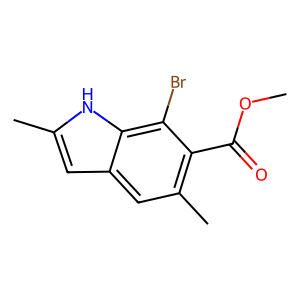

In [ ]:
match_smiles = results['SMILES'][1376]
print(match_smiles)

mol = Chem.MolFromSmiles(match_smiles)

Draw.MolToImage(mol)


Has substructure match: False


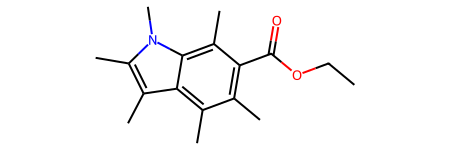

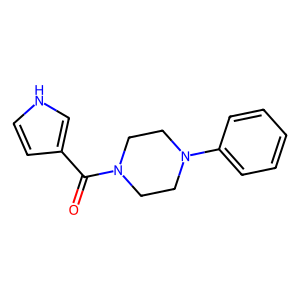

In [ ]:
# SMILES string
smiles_1 = "O=C(Nc1nccs1)c1ccccc1"

# Convert SMILES to RDKit molecule object
mol = Chem.MolFromSmiles(smiles_1)

# Draw the molecule
Draw.MolToImage(mol)

In [ ]:
calculate_properties(smiles_1)

(323.4400000000001,
 2.9060000000000006,
 39.34,
 3.568958613692356,
 0.9432093554831017)

In [ ]:
#from molgpt
def check_novelty(gen_smiles, train_smiles): # gen: say 788, train: 120803
    if len(gen_smiles) == 0:
        novel_ratio = 0.
    else:
        duplicates = [1 for mol in gen_smiles if mol in train_smiles]  # [1]*45
        novel = len(gen_smiles) - sum(duplicates)  # 788-45=743
        novel_ratio = novel*100./len(gen_smiles)  # 743*100/788=94.289
    print("novelty: {:.3f}%".format(novel_ratio))
    return novel_ratio

def canonic_smiles(smiles_or_mol):
    mol = get_mol(smiles_or_mol)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

    #Experimental Class for Smiles Enumeration, Iterator and SmilesIterator adapted from Keras 1.2.2

In [ ]:
canon_smiles = [canonic_smiles(s) for s in results['SMILES']]
unique_smiles = list(set(canon_smiles))
novel_ratio = check_novelty(unique_smiles, set(train_data_o['SMILES']))   # replace 'source' with 'split' for moses

#print(f'Condition: {c}')
#print(f'Scaffold: {j}')
print('Valid ratio: ', np.round(len(results)/(512*gen_iter), 3))
print('Unique ratio: ', np.round(len(unique_smiles)/len(results), 3))
print('Novelty ratio: ', np.round(novel_ratio/100, 3))

novelty: 100.000%
Valid ratio:  0.302
Unique ratio:  0.988
Novelty ratio:  1.0


In [ ]:
molecules = combined_df['molecule'].tolist()

In [ ]:
for i, mol in enumerate(molecules):
    img = Draw.MolToImage(mol, size = (300, 300))
    img.save(f'/home/10714016/gpt/result/combined_data/gen_molecules/lsd_derivative/molecule_{i+1}.jpg')

In [ ]:
df = results

In [ ]:
from rdkit import Chem
from rdkit.Chem import Crippen
from rdkit.Chem import QED
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))

import sascorer


In [ ]:
def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None, None, None, None, None
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    sas = sascorer.calculateScore(mol)
    qed = QED.qed(mol)

    return mw, logp, tpsa, sas, qed



In [ ]:
smiles = "O=C(c1cc[nH]c1)N1CCN(c2ccccc2)CC1"
mol = Chem.MolFromSmiles(smiles)
logp = Descriptors.MolLogP(mol)
logp

1.9770999999999999

In [ ]:
df['MW'], df['logP'], df['TPSA'], df['SAS'], df['QED']  = zip(*df['SMILES'].apply(lambda x: calculate_properties(x)))

df.dropna(inplace=True)

In [ ]:
df = df.head(1000)
df

,SMILES,molecule,MW,logP,TPSA,SAS,QED
0,N#Cc1ccc([N+](=O)[O-])c(N(CCC2(C#N)CC2)c2ccccc...,<rdkit.Chem.rdchem.Mol object at 0x7fa6f811cf90>,332.363,4.29846,93.96,2.869037,0.580440
1,Cc1[nH]c(C(C)C)cc1C(=O)N1CCN(c2ccccc2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f811cf20>,311.429,3.40892,39.34,2.237624,0.943293
2,CC(C#N)(C#N)c1ccccc1N1CCN(C(=O)c2ccc[nH]2)C1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f811d000>,319.368,2.23946,86.92,3.126575,0.939615
3,Cc1cc(C(=O)N2CCN(CC#Cc3ccccc3C)CC2)c(C)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f811d070>,335.451,2.74946,39.34,2.488121,0.857377
4,CC1CN(C(=O)c2ccccc2)CCN1C(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f811d0e0>,308.381,2.67330,40.62,2.140495,0.855607
...,...,...,...,...,...,...,...
995,N#CCC(C#N)c1c[nH]c(N2CCN(c3ccccc3)CC2)c1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f81b5fc0>,305.385,2.86216,69.85,3.322493,0.942661
996,CCCc1ccccc1N1CCN(C(=O)O)C=CC=C1N,<rdkit.Chem.rdchem.Mol object at 0x7fa6f81b6030>,287.363,2.75290,69.80,2.949586,0.896533
997,CC(C)CC(C#N)c1cccc(N2CCN(C(=O)c3ccc[nH]3)C2)c1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f81b60a0>,336.439,3.58788,63.13,3.262611,0.907397
998,N#CCc1cc[nH]c1CN1CCN(C(=O)c2ccccc2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7fa6f81b6110>,308.385,2.03878,63.13,2.392248,0.939881


In [ ]:
df.to_csv('/home/10714016/gpt/result/combined_data/df/0/logp_5.csv')

In [ ]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

import re

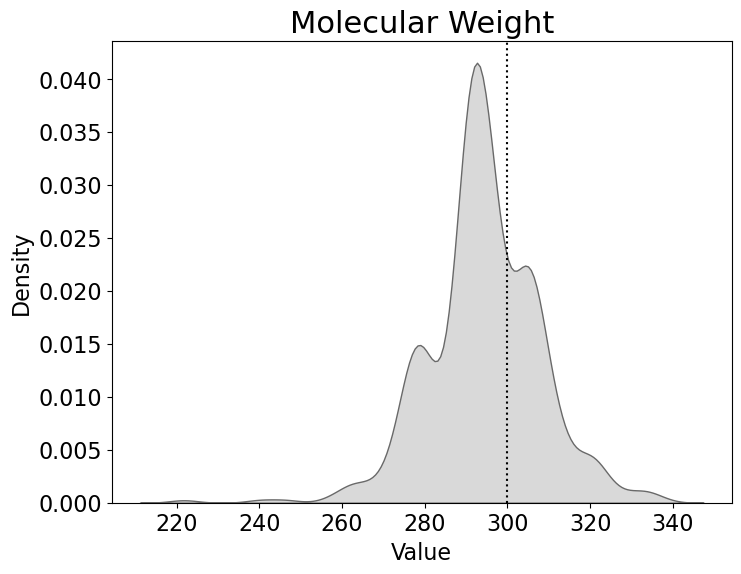

In [ ]:
plt.figure(figsize=(8, 6))

sns.kdeplot(data=df['MW'], color = 'dimgray', fill=True)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=300, color='black', linestyle='dotted')

matplotlib.rcParams.update({'font.size': 16})

plt.xlabel('Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Molecular Weight', fontsize=22)

plt.savefig('/home/10714016/gpt/result/combined_data/gen_prop/MW_mode_gray.jpg')
plt.show()

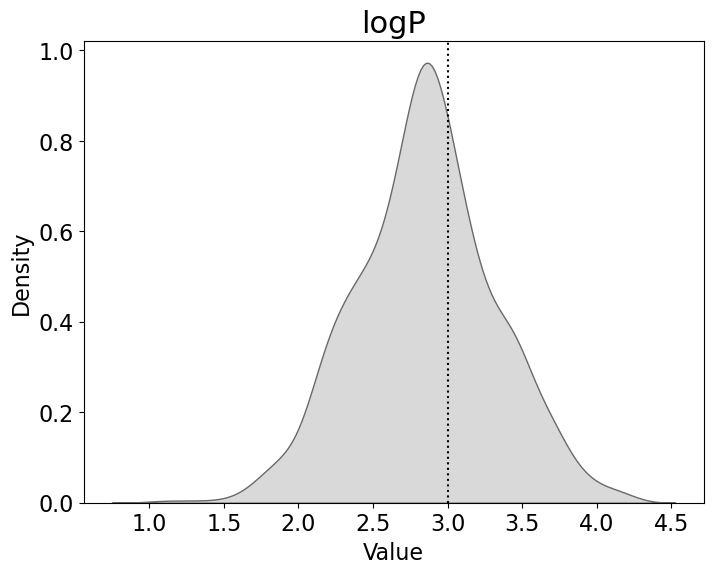

In [ ]:
plt.figure(figsize=(8, 6))

sns.kdeplot(data=df['logP'], color = 'dimgray', fill=True)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=3.0, color='black', linestyle='dotted')

matplotlib.rcParams.update({'font.size': 16})

plt.xlabel('Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('logP', fontsize=22)

plt.savefig('/home/10714016/gpt/result/combined_data/gen_prop/logP_mode_gray.jpg')
plt.show()

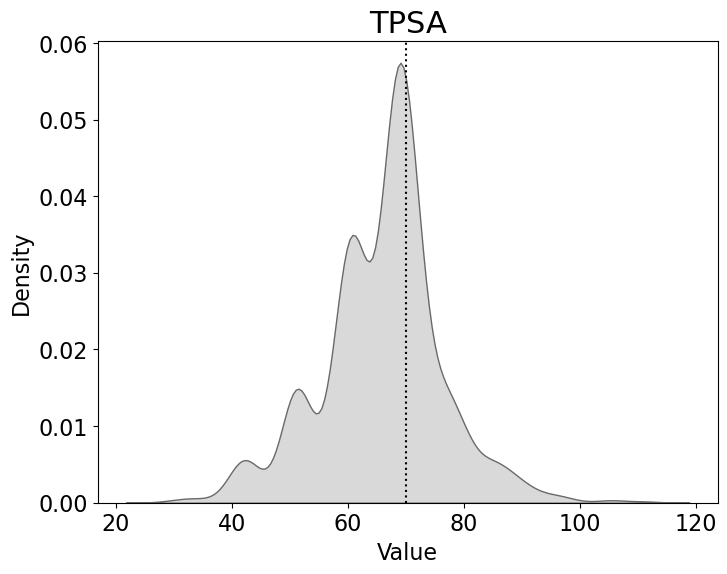

In [ ]:
plt.figure(figsize=(8, 6))

sns.kdeplot(data=df['TPSA'], color = 'dimgray', fill=True)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=70, color='black', linestyle='dotted')

matplotlib.rcParams.update({'font.size': 16})

plt.xlabel('Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('TPSA', fontsize=22)

plt.savefig('/home/10714016/gpt/result/combined_data/gen_prop/TPSA_mode_gray.jpg')
plt.show()

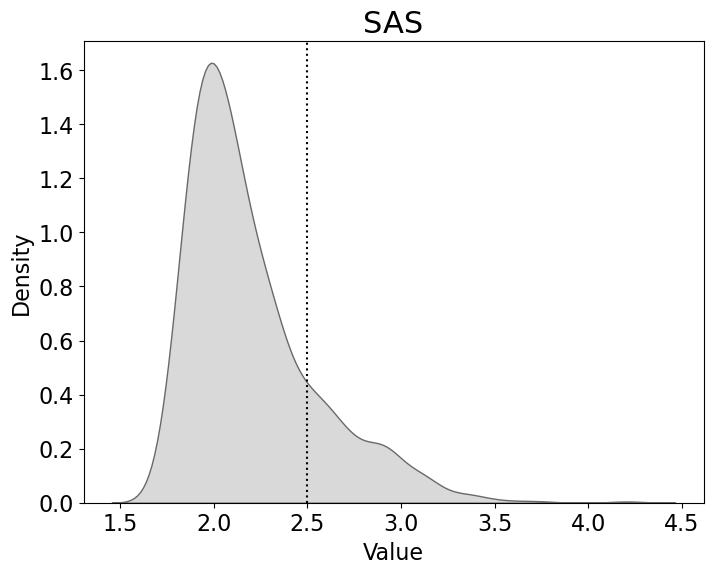

In [ ]:
plt.figure(figsize=(8, 6))

sns.kdeplot(data=df['SAS'], color = 'dimgray', fill=True)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=2.5, color='black', linestyle='dotted')

matplotlib.rcParams.update({'font.size': 16})

plt.xlabel('Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('SAS', fontsize=22)

plt.savefig('/home/10714016/gpt/result/combined_data/gen_prop/SAS_mode_gray.jpg')
plt.show()

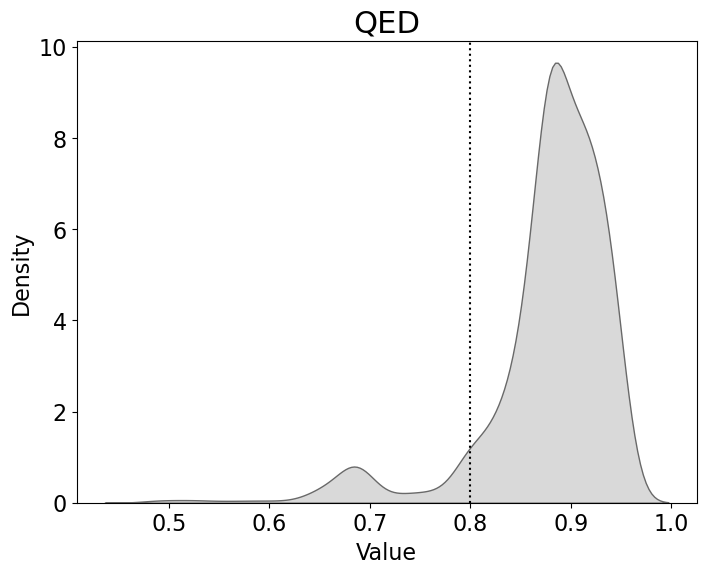

In [ ]:
plt.figure(figsize=(8, 6))

sns.kdeplot(data=df['QED'], color = 'dimgray', fill=True)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=0.8, color='black', linestyle='dotted')

matplotlib.rcParams.update({'font.size': 16})

plt.xlabel('Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('QED', fontsize=22)

plt.savefig('/home/10714016/gpt/result/combined_data/gen_prop/QED_mode_gray.jpg')
plt.show()